# Load the data

In [3]:
import pandas as pd
import numpy as np
import gc
import itertools
from tqdm import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
DATA_FOLDER = '../data/'
train     = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train_v2.csv'))
items     = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_cats = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops     = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
test      = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))
test['date_block_num'] = 34
groupby_cols = ['date_block_num', 'shop_id', 'item_id']

# Add some features

In [2]:
#category
cat = items[['item_id', 'item_category_id']].drop_duplicates()
cat.set_index(['item_id'], inplace=True)
cat = cat.item_category_id
train['cat'] = train.item_id.map(cat)

#meta_category   games, gifts, work, etc.
item_cats['meta_cat'] = item_cats.item_category_name.apply(lambda x: x.split(' ')[0])
item_cats['meta_cat'] = pd.Categorical(item_cats.meta_cat).codes
item_cats.set_index(['item_category_id'], inplace=True)
meta_cat = item_cats.meta_cat
train['meta_cat'] = train.cat.map(meta_cat)

#city
shops['city'] = shops.shop_name.apply(lambda x: str.replace(x, '!', '')).apply(lambda x: x.split(' ')[0])
shops['city'] = pd.Categorical(shops['city']).codes
city = shops.city
train['city'] = train.shop_id.map(city)

#year
year = pd.concat([train.date_block_num, train.date.apply(lambda x: int(x.split('.')[2]))], axis=1).drop_duplicates()
year.set_index(['date_block_num'], inplace=True)
year = year.date.append( pd.Series([2015], index=[34]) )

#month
month = pd.concat([train.date_block_num, train.date.apply(lambda x: int(x.split('.')[1]))], axis=1).drop_duplicates()
month.set_index(['date_block_num'], inplace=True)
month = month.date.append( pd.Series([11], index=[34]) )

In [3]:
all_shops_items = []

for block_num in train['date_block_num'].unique():
    unique_shops = train[ train['date_block_num']==block_num ]['shop_id'].unique()
    unique_items = train[ train['date_block_num']==block_num ]['item_id'].unique()
    all_shops_items.append( np.array( list( itertools.product([block_num], unique_shops, unique_items) ), dtype='int32' ) )

df = pd.DataFrame( np.vstack( all_shops_items ), columns=groupby_cols , dtype='int32')
df = df.append(test )

df['ID'] = df.ID.fillna(-1).astype('int32')

df['year'] = df.date_block_num.map(year)
df['month'] = df.date_block_num.map(month)
df['cat'] = df.item_id.map(cat)
df['meta_cat'] = df.cat.map(meta_cat)
df['city'] = df.shop_id.map(city)
train['cat'] = train.item_id.map(cat)

c:\users\cy\appdata\local\programs\python\python36\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [4]:
df.sample(5)

,ID,date_block_num,item_id,shop_id,year,month,cat,meta_cat,city
8511907,-1,24,14351,59,2015,1,37,7,30
7751129,-1,21,15452,43,2014,10,63,10,19
1909401,-1,5,13852,44,2013,6,38,7,20
8329067,-1,23,20673,19,2014,12,72,10,12
9471237,-1,27,19050,39,2015,4,55,9,18


# Some plots

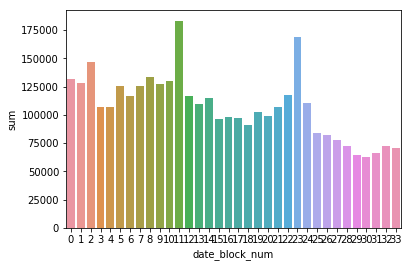

In [5]:
gb = train.groupby(by=['date_block_num'], as_index=False).agg({ 'item_cnt_day': ['sum']})
sns.barplot(x=gb['date_block_num'], y=gb['item_cnt_day']['sum'])

Most of the target values are just Zeros.

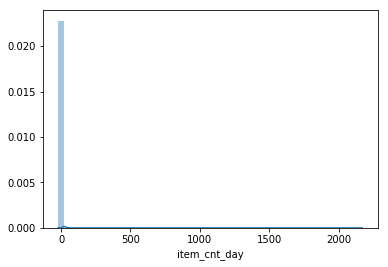

In [6]:
sns.distplot(train['item_cnt_day'])

Zeros and ones are just dominating.

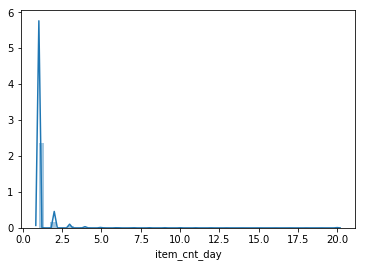

In [7]:
sns.distplot( train[ train['item_cnt_day'] > 0 ]['item_cnt_day'].clip(0, 20) )

# Calculating different aggregations

In [8]:
gb = train.groupby(by=groupby_cols, as_index=False).agg({ 'item_cnt_day': ['sum']})
gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_cnt_day_sum':'target'}, inplace=True)
df = pd.merge(df, gb, how='left', on=groupby_cols)

gb = train.groupby(by=['date_block_num', 'item_id'], as_index=False).agg({'item_cnt_day':['sum']})
gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_cnt_day_sum':'target_item'}, inplace=True)
df = pd.merge(df, gb, how='left', on=['date_block_num', 'item_id'])

gb = train.groupby(by=['date_block_num', 'shop_id'], as_index=False).agg({'item_cnt_day':['sum']})
gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_cnt_day_sum':'target_shop'}, inplace=True)
df = pd.merge(df, gb, how='left', on=['date_block_num', 'shop_id'])

gb = train.groupby( by=['date_block_num', 'cat'], as_index=False).agg({ 'item_cnt_day': ['sum'] })
gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_cnt_day_sum':'target_cat'}, inplace=True)
df = pd.merge(df, gb, how='left', on=['date_block_num', 'cat'])

gb = train.groupby(by=['date_block_num', 'item_id'], as_index=False).agg({'item_price':['mean', 'max']})
gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_price_mean':'target_price_mean', 'item_price_max':'target_price_max'}, inplace=True)
df = pd.merge(df, gb, how='left', on=['date_block_num', 'item_id'])

# Clipping some outlier prices

In [9]:
df['target_price_mean'] = np.minimum(df['target_price_mean'], df['target_price_mean'].quantile(0.99))
df['target_price_max'] = np.minimum(df['target_price_max'], df['target_price_max'].quantile(0.99))

df.fillna(0, inplace=True)
df['target'] = df['target'].clip(0, 20)
df['target_zero'] = (df['target'] > 0).astype("int32")

c:\users\cy\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in minimum
  """Entry point for launching an IPython kernel.
c:\users\cy\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in minimum
  


# Mean Encodings

In [10]:
%%time
for enc_cols in [['shop_id', 'cat'], ['shop_id', 'item_id'], ['shop_id'], ['item_id']]:
    
    col = '_'.join(['enc', *enc_cols])
    col2 = '_'.join(['enc_max', *enc_cols])
    df[col] = np.nan
    df[col2] = np.nan
    
    print(col, col2)
    
    for d in tqdm_notebook(df.date_block_num.unique()):
        

        f1 = df.date_block_num < d
        f2 = df.date_block_num == d

        gb = df.loc[f1].groupby(enc_cols)[['target']].mean().reset_index()
        enc = df.loc[f2][enc_cols].merge(gb, on=enc_cols, how='left' )[['target']].copy()
        enc.set_index(df.loc[f2].index, inplace=True)
        df.loc[f2, col] = enc['target']
        
        gb = df.loc[f1].groupby(enc_cols)[['target']].max().reset_index()
        enc = df.loc[f2][enc_cols].merge(gb, on=enc_cols, how='left' )[['target']].copy()
        enc.set_index(df.loc[f2].index, inplace=True)
        df.loc[f2, col2] = enc['target']
        

enc_shop_id_cat enc_max_shop_id_cat



enc_shop_id_item_id enc_max_shop_id_item_id



enc_shop_id enc_max_shop_id



enc_item_id enc_max_item_id



Wall time: 5min 51s


In [11]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float32_cols = [c for c in df if df[c].dtype == "float64"]
    int32_cols = [c for c in df if df[c].dtype in ["int64", "int16", "int8"] ]
            
    # Downcast
    df[float32_cols] = df[float32_cols].astype(np.float32)
    df[int32_cols]   = df[int32_cols].astype(np.int32)
        
    return df

In [12]:
df.fillna(0, inplace=True)
df = downcast_dtypes(df)

# Historical values

In [13]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import os
import gc
from time import sleep

groupby_cols = ['date_block_num', 'shop_id', 'item_id']
shift_range = [1, 2, 3, 4, 5, 12]

# Features Interaction

In [26]:
df['target_trend_1_2'] = df['target_lag_1'] - df['target_lag_2']
df['target_predict_1_2'] = df['target_lag_1']*2 - df['target_lag_2']

df['target_trend_3_4'] = df['target_lag_1'] + df['target_lag_2'] - df['target_lag_3'] - df['target_lag_4']
df['target_predict_3_4'] = (df['target_lag_1'] + df['target_lag_2'])*2 - df['target_lag_3'] - df['target_lag_4']

df['target_item_trend_1_2'] = df['target_item_lag_1'] - df['target_item_lag_2']
df['target_item_trend_3_4'] = df['target_item_lag_1'] + df['target_item_lag_2'] - df['target_item_lag_3'] - df['target_item_lag_4']
df['target_shop_trend_1_2'] = df['target_shop_lag_1'] - df['target_shop_lag_2']
df['target_shop_trend_3_4'] = df['target_shop_lag_1'] + df['target_shop_lag_2'] - df['target_shop_lag_3'] - df['target_shop_lag_4']

In [27]:
df = downcast_dtypes(df)
df.to_pickle("df.pkl")

# XGBoost part

In [1]:
import pandas as pd
import numpy as np
import os
import gc
import xgboost as xgb
from sklearn.model_selection import train_test_split
import pickle
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_pickle("df.pkl")

drop_columns = [c for c in df if c[-1] not in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0'] and c.startswith('target')]
drop_columns += ['ID']
features = df.columns.difference( drop_columns )

f0 = df.date_block_num < 34
f1 = df.date_block_num == 34

train, val = train_test_split(df[f0], test_size=0.2, stratify=df[f0]['target'])
test = df[f1]

In [3]:
Train = xgb.DMatrix( train[features], train['target'] )
Val = xgb.DMatrix( val[features], val['target'] )
Test = xgb.DMatrix( test[features])

c:\users\cy\desktop\testjupyter\lib\site-packages\xgboost-0.83.dev0-py3.6.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\cy\desktop\testjupyter\lib\site-packages\xgboost-0.83.dev0-py3.6.egg\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [4]:
del df
gc.collect()

17

In [5]:
xgb_params = {'booster': 'gbtree',
          'eta': .1,
          'min_child_weight': 50,
          'max_depth': 6,
          'objective': 'reg:linear',
          'eval_metric': 'rmse',
          'silent': False,
          'tree_method':'gpu_hist'}

model = xgb.train(xgb_params, Train, 1000, [(Train, 'Train'), (Val, 'Val')], early_stopping_rounds=10, verbose_eval=1)

[16:45:31] WARNING: C:/dev/libs/xgboost/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Train-rmse:1.18928	Val-rmse:1.18911
Multiple eval metrics have been passed: 'Val-rmse' will be used for early stopping.

Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Train-rmse:1.14707	Val-rmse:1.14677
[2]	Train-rmse:1.11118	Val-rmse:1.11084
[3]	Train-rmse:1.08092	Val-rmse:1.08061
[4]	Train-rmse:1.05484	Val-rmse:1.05454
[5]	Train-rmse:1.03349	Val-rmse:1.0332
[6]	Train-rmse:1.01474	Val-rmse:1.01442
[7]	Train-rmse:0.999288	Val-rmse:0.999013
[8]	Train-rmse:0.985688	Val-rmse:0.985307
[9]	Train-rmse:0.974744	Val-rmse:0.974437
[10]	Train-rmse:0.964891	Val-rmse:0.9647
[11]	Train-rmse:0.956689	Val-rmse:0.956541
[12]	Train-rmse:0.94986	Val-rmse:0.949721
[13]	Train-rmse:0.94404	Val-rmse:0.944075
[14]	Train-rmse:0.938732	Val-rmse:0.938846
[15]	Train-rmse:0.934223	Val-rmse:0.934448
[16]	Train-rmse:0.930344	Val-rmse:0.930586
[17]	Train-rmse:0.926

[184]	Train-rmse:0.85757	Val-rmse:0.864229
[185]	Train-rmse:0.857348	Val-rmse:0.86406
[186]	Train-rmse:0.857284	Val-rmse:0.86401
[187]	Train-rmse:0.856595	Val-rmse:0.863409
[188]	Train-rmse:0.856426	Val-rmse:0.863273
[189]	Train-rmse:0.855941	Val-rmse:0.862774
[190]	Train-rmse:0.855689	Val-rmse:0.862554
[191]	Train-rmse:0.855569	Val-rmse:0.862491
[192]	Train-rmse:0.855467	Val-rmse:0.862427
[193]	Train-rmse:0.855392	Val-rmse:0.862392
[194]	Train-rmse:0.855267	Val-rmse:0.862276
[195]	Train-rmse:0.854606	Val-rmse:0.861628
[196]	Train-rmse:0.854533	Val-rmse:0.861583
[197]	Train-rmse:0.854291	Val-rmse:0.86138
[198]	Train-rmse:0.854089	Val-rmse:0.861241
[199]	Train-rmse:0.853903	Val-rmse:0.86108
[200]	Train-rmse:0.853789	Val-rmse:0.860999
[201]	Train-rmse:0.853577	Val-rmse:0.860798
[202]	Train-rmse:0.853502	Val-rmse:0.860743
[203]	Train-rmse:0.853307	Val-rmse:0.8606
[204]	Train-rmse:0.853231	Val-rmse:0.860563
[205]	Train-rmse:0.853098	Val-rmse:0.860476
[206]	Train-rmse:0.853009	Val-rmse:0.86

[372]	Train-rmse:0.833342	Val-rmse:0.845616
[373]	Train-rmse:0.833283	Val-rmse:0.845611
[374]	Train-rmse:0.833255	Val-rmse:0.845602
[375]	Train-rmse:0.833195	Val-rmse:0.845587
[376]	Train-rmse:0.833143	Val-rmse:0.845541
[377]	Train-rmse:0.833089	Val-rmse:0.845533
[378]	Train-rmse:0.832957	Val-rmse:0.845419
[379]	Train-rmse:0.832621	Val-rmse:0.84513
[380]	Train-rmse:0.832491	Val-rmse:0.845037
[381]	Train-rmse:0.832399	Val-rmse:0.844955
[382]	Train-rmse:0.832387	Val-rmse:0.844949
[383]	Train-rmse:0.832317	Val-rmse:0.844901
[384]	Train-rmse:0.832251	Val-rmse:0.844844
[385]	Train-rmse:0.832196	Val-rmse:0.844806
[386]	Train-rmse:0.83213	Val-rmse:0.844767
[387]	Train-rmse:0.832074	Val-rmse:0.844726
[388]	Train-rmse:0.832028	Val-rmse:0.844695
[389]	Train-rmse:0.831979	Val-rmse:0.844684
[390]	Train-rmse:0.831952	Val-rmse:0.844676
[391]	Train-rmse:0.831848	Val-rmse:0.844593
[392]	Train-rmse:0.831326	Val-rmse:0.844104
[393]	Train-rmse:0.831261	Val-rmse:0.844055
[394]	Train-rmse:0.831209	Val-rmse

[560]	Train-rmse:0.816241	Val-rmse:0.833054
[561]	Train-rmse:0.816217	Val-rmse:0.83306
[562]	Train-rmse:0.816169	Val-rmse:0.833032
[563]	Train-rmse:0.816085	Val-rmse:0.832974
[564]	Train-rmse:0.816054	Val-rmse:0.832962
[565]	Train-rmse:0.815982	Val-rmse:0.832943
[566]	Train-rmse:0.815919	Val-rmse:0.832922
[567]	Train-rmse:0.815909	Val-rmse:0.832921
[568]	Train-rmse:0.815854	Val-rmse:0.832881
[569]	Train-rmse:0.815659	Val-rmse:0.83269
[570]	Train-rmse:0.815614	Val-rmse:0.832669
[571]	Train-rmse:0.815588	Val-rmse:0.832652
[572]	Train-rmse:0.815496	Val-rmse:0.832591
[573]	Train-rmse:0.815454	Val-rmse:0.832576
[574]	Train-rmse:0.815345	Val-rmse:0.832498
[575]	Train-rmse:0.815293	Val-rmse:0.832467
[576]	Train-rmse:0.814688	Val-rmse:0.831926
[577]	Train-rmse:0.814595	Val-rmse:0.831839
[578]	Train-rmse:0.814551	Val-rmse:0.831817
[579]	Train-rmse:0.814505	Val-rmse:0.831776
[580]	Train-rmse:0.814484	Val-rmse:0.831771
[581]	Train-rmse:0.814436	Val-rmse:0.831748
[582]	Train-rmse:0.814341	Val-rmse

[748]	Train-rmse:0.80383	Val-rmse:0.82439
[749]	Train-rmse:0.803807	Val-rmse:0.824387
[750]	Train-rmse:0.803706	Val-rmse:0.824302
[751]	Train-rmse:0.803687	Val-rmse:0.824311
[752]	Train-rmse:0.803666	Val-rmse:0.824297
[753]	Train-rmse:0.803606	Val-rmse:0.824264
[754]	Train-rmse:0.80357	Val-rmse:0.824242
[755]	Train-rmse:0.803495	Val-rmse:0.824168
[756]	Train-rmse:0.803462	Val-rmse:0.824153
[757]	Train-rmse:0.803439	Val-rmse:0.824154
[758]	Train-rmse:0.803383	Val-rmse:0.82411
[759]	Train-rmse:0.803347	Val-rmse:0.82409
[760]	Train-rmse:0.803325	Val-rmse:0.82408
[761]	Train-rmse:0.803286	Val-rmse:0.824048
[762]	Train-rmse:0.803219	Val-rmse:0.824031
[763]	Train-rmse:0.803188	Val-rmse:0.82403
[764]	Train-rmse:0.803118	Val-rmse:0.823981
[765]	Train-rmse:0.803055	Val-rmse:0.823934
[766]	Train-rmse:0.803014	Val-rmse:0.82391
[767]	Train-rmse:0.802929	Val-rmse:0.823852
[768]	Train-rmse:0.802767	Val-rmse:0.823737
[769]	Train-rmse:0.802739	Val-rmse:0.823725
[770]	Train-rmse:0.802692	Val-rmse:0.823

[936]	Train-rmse:0.794548	Val-rmse:0.818357
[937]	Train-rmse:0.794499	Val-rmse:0.818328
[938]	Train-rmse:0.794463	Val-rmse:0.818305
[939]	Train-rmse:0.794436	Val-rmse:0.818291
[940]	Train-rmse:0.79441	Val-rmse:0.818279
[941]	Train-rmse:0.794331	Val-rmse:0.818219
[942]	Train-rmse:0.794293	Val-rmse:0.818199
[943]	Train-rmse:0.794277	Val-rmse:0.818197
[944]	Train-rmse:0.794246	Val-rmse:0.818206
[945]	Train-rmse:0.794158	Val-rmse:0.818131
[946]	Train-rmse:0.794135	Val-rmse:0.818124
[947]	Train-rmse:0.794106	Val-rmse:0.818126
[948]	Train-rmse:0.794084	Val-rmse:0.818128
[949]	Train-rmse:0.794068	Val-rmse:0.818122
[950]	Train-rmse:0.794011	Val-rmse:0.818086
[951]	Train-rmse:0.793985	Val-rmse:0.818083
[952]	Train-rmse:0.79396	Val-rmse:0.818078
[953]	Train-rmse:0.793941	Val-rmse:0.818073
[954]	Train-rmse:0.793927	Val-rmse:0.818069
[955]	Train-rmse:0.793914	Val-rmse:0.818062
[956]	Train-rmse:0.793905	Val-rmse:0.818059
[957]	Train-rmse:0.793859	Val-rmse:0.818031
[958]	Train-rmse:0.793826	Val-rmse

In [6]:
test['item_cnt_month'] = model.predict(Test).clip(0, 20)
test[['ID', 'item_cnt_month']].sort_values('ID').to_csv('TryIsTheBestWay.csv', index=False)

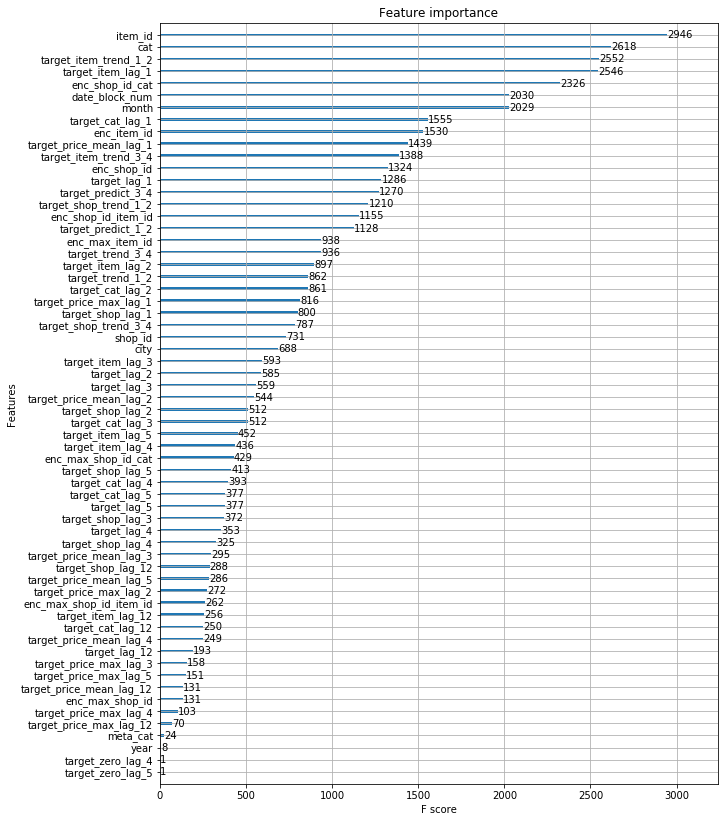

In [12]:
from xgboost import plot_importance
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
plot_features(model, (10,14))
# xgb.plot_importance(booster=model, max_num_features=40)

# Other method
### sklearn Linear Regression

In [ ]:
from sklearn import linear_model
ts = time.time()
clf = linear_model.Ridge(alpha=.5)
clf.fit(X_train, Y_train)
time.time() - ts
Y_pred = clf.predict(X_valid).clip(0, 20)
Y_test = clf.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('LinearRegression_submission.csv', index=False)

### Split trainind data and ensemble two xgboost model

In [ ]:
X_train1 = X_train[X_train.shop_id < 30]
Y_train1 = Y_train[X_train.shop_id < 30]
X_valid1 = X_valid[X_valid.shop_id < 30]
Y_valid1 = Y_valid[X_valid.shop_id < 30]

X_train2 = X_train[X_train.shop_id >= 30]
Y_train2 = Y_train[X_train.shop_id >= 30]
X_valid2 = X_valid[X_valid.shop_id >= 30]
Y_valid2 = Y_valid[X_valid.shop_id >= 30]

models = []
for i in range(2):
    if i == 0:
        xtrain = X_train1
        ytrain = Y_train1
        xval = X_valid1
        yval = Y_valid1
    else:
        xtrain = X_train2
        ytrain = Y_train2
        xval = X_valid2
        yval = Y_valid2
    
    model = XGBRegressor(
        max_depth=8,
        n_estimators=1000,
        min_child_weight=300, 
        colsample_bytree=0.8, 
        subsample=0.8,
        eta=0.3,    
        seed=42)

    model.fit(
        xtrain, 
        ytrain, 
        eval_metric="rmse", 
        eval_set=[(xtrain, ytrain), (xval, yval)], 
        verbose=True, 
        early_stopping_rounds = 10)
    models.append(model)

X_test1 = X_test[X_test.shop_id < 30]
X_test2 = X_test[X_test.shop_id >= 30]
Y_test1 = models[0].predict(X_test1).clip(0, 20)
Y_test2 = models[1].predict(X_test2).clip(0, 20)
Y_test = np.concatenate((Y_test1, Y_test2))

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('LinearRegression_submission.csv', index=False)

### Mxnet lstm model

In [ ]:
class LSTM(nn.HybridBlock):
    def __init__(self):
        super(LSTM, self).__init__()
        self.model = nn.HybridSequential()
        with self.model.name_scope():
            self.model.add(
                mx.gluon.rnn.LSTM(256),
                nn.Dropout(0.2),
                mx.gluon.rnn.LSTM(512),
                nn.Dropout(0.2),
                mx.gluon.rnn.LSTM(1024),
                nn.Dense(1)
            )
    def hybrid_forward(self, F, x, *args, **kwargs):
        return self.model(x)

### Mxnet cnn model

In [ ]:
def conv_block(channel, kernel=1, stride=1, pad=0):
    blc = nn.HybridSequential()
    blc.add(
        nn.Conv1D(channel, kernel_size=kernel, strides=1, padding=pad),
        nn.BatchNorm(),
        nn.Activation('relu')
    )
    return blc

class CNN(nn.HybridBlock):
    def __init__(self):
        super(CNN, self).__init__()
        self.model = nn.HybridSequential()
        with self.model.name_scope():
            self.model.add(
                conv_block(64),
                nn.Flatten(),
                nn.Dense(10, activation='relu'),
                nn.Dense(1)
            )
    def hybrid_forward(self, F, x, *args, **kwargs):
        return self.model(x)

### Complement the training data according to feature importance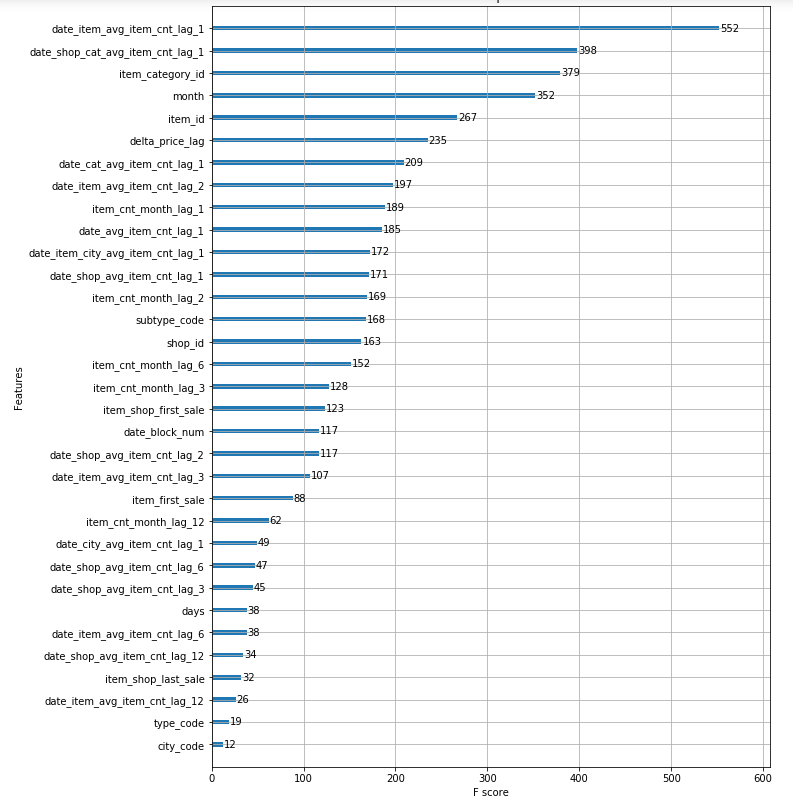

In [ ]:
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,4,5,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)